## ETF-Level Quantitative Screening (Pre-Portfolio Selection)

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
returns_df = pd.read_csv("../processed/etf_returns.csv", parse_dates=["Date"])
returns_df.head()

,Date,Adj_Close,Ticker,Market,Daily_Return,Cumulative_Return
0,2014-01-02,56.922413,BND,US,NaN,NaN
1,2014-01-03,56.929501,BND,US,0.000125,0.000125
2,2014-01-06,56.979229,BND,US,0.000874,0.000998
3,2014-01-07,57.050289,BND,US,0.001247,0.002247
4,2014-01-08,56.865547,BND,US,-0.003238,-0.000999


In [3]:
TRADING_DAYS = 252

etf_metrics = (
    returns_df
    .groupby("Ticker")["Daily_Return"]
    .agg(
        annual_return=lambda x: (1 + x).prod() ** (TRADING_DAYS / len(x)) - 1,
        annual_volatility=lambda x: x.std() * np.sqrt(TRADING_DAYS)
    )
)

In [4]:
def max_drawdown(returns):
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    return drawdown.min()

etf_drawdowns = (
    returns_df
    .groupby("Ticker")["Daily_Return"]
    .apply(max_drawdown)
)

etf_metrics["max_drawdown"] = etf_drawdowns


In [5]:
RISK_FREE_RATE = 0.02  # 2% assumed

etf_metrics["sharpe_ratio"] = (
    (etf_metrics["annual_return"] - RISK_FREE_RATE)
    / etf_metrics["annual_volatility"]
)


In [6]:
etf_categories = {
    "VFV.TO": "Equity",
    "SPY": "Equity",
    "XTI": "Equity",
    "XIC.TO": "Equity",
    "SPLV": "Low Vol Equity",
    "BND": "Bond",
    "ZAG.TO": "Bond",
    "VCN.TO": "Equity"
}

etf_metrics["category"] = etf_metrics.index.map(etf_categories)

In [7]:
etf_metrics = etf_metrics.sort_values("annual_return", ascending=False)
etf_metrics


,annual_return,annual_volatility,max_drawdown,sharpe_ratio,category
Ticker,,,,,
VFV.TO,0.156501,0.161412,-0.274288,0.845666,Equity
SPY,0.135718,0.173116,-0.337173,0.668440,Equity
VTI,0.130703,0.176379,-0.350003,0.627646,NaN
SCHD,0.111211,0.161333,-0.333671,0.565358,NaN
XIC.TO,0.108270,0.145489,-0.372117,0.606712,Equity
VDY.TO,0.107866,0.156687,-0.392112,0.560771,NaN
VCN.TO,0.106610,0.146772,-0.373204,0.590099,Equity
SPLV,0.091870,0.149884,-0.362614,0.479500,Low Vol Equity
ZAG.TO,0.024752,0.066694,-0.180332,0.071252,Bond


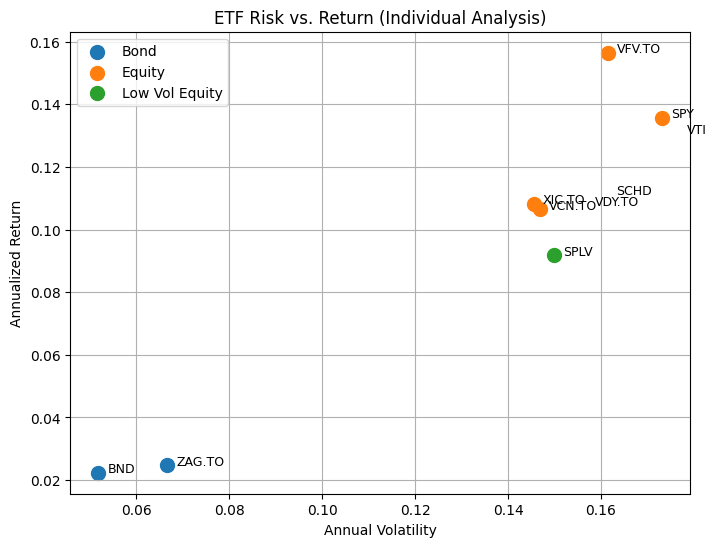

In [8]:
plt.figure(figsize=(8,6))

for category, group in etf_metrics.groupby("category"):
    plt.scatter(
        group["annual_volatility"],
        group["annual_return"],
        label=category,
        s=100
    )

for ticker, row in etf_metrics.iterrows():
    plt.text(
        row["annual_volatility"] + 0.002,
        row["annual_return"],
        ticker,
        fontsize=9
    )

plt.xlabel("Annual Volatility")
plt.ylabel("Annualized Return")
plt.title("ETF Risk vs. Return (Individual Analysis)")
plt.legend()
plt.grid(True)
plt.show()

## Rolling Volatility Analysis (ETF Stability Over Time)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("../processed/etf_returns.csv")

# 2) Make sure Date is datetime + sort correctly
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values(["Ticker", "Date"]).reset_index(drop=True)

df.head()


,Date,Adj_Close,Ticker,Market,Daily_Return,Cumulative_Return
0,2014-01-02,56.922413,BND,US,NaN,NaN
1,2014-01-03,56.929501,BND,US,0.000125,0.000125
2,2014-01-06,56.979229,BND,US,0.000874,0.000998
3,2014-01-07,57.050289,BND,US,0.001247,0.002247
4,2014-01-08,56.865547,BND,US,-0.003238,-0.000999


In [10]:
# Daily returns
df["Daily_Return"] = df.groupby("Ticker")["Adj_Close"].pct_change()

# Rolling 12-month volatility (annualized)
WINDOW = 252
df["Rolling_Volatility"] = (
    df.groupby("Ticker")["Daily_Return"]
      .rolling(WINDOW)
      .std()
      .reset_index(level=0, drop=True)
      * (252 ** 0.5)
)

df[["Date", "Ticker", "Adj_Close", "Daily_Return", "Rolling_Volatility"]].tail()

,Date,Ticker,Adj_Close,Daily_Return,Rolling_Volatility
30295,2026-01-19,ZAG.TO,13.85,-0.000721,0.048877
30296,2026-01-20,ZAG.TO,13.81,-0.002888,0.048893
30297,2026-01-21,ZAG.TO,13.82,0.000724,0.048879
30298,2026-01-22,ZAG.TO,13.85,0.002171,0.048879
30299,2026-01-23,ZAG.TO,13.85,0.000000,0.048676


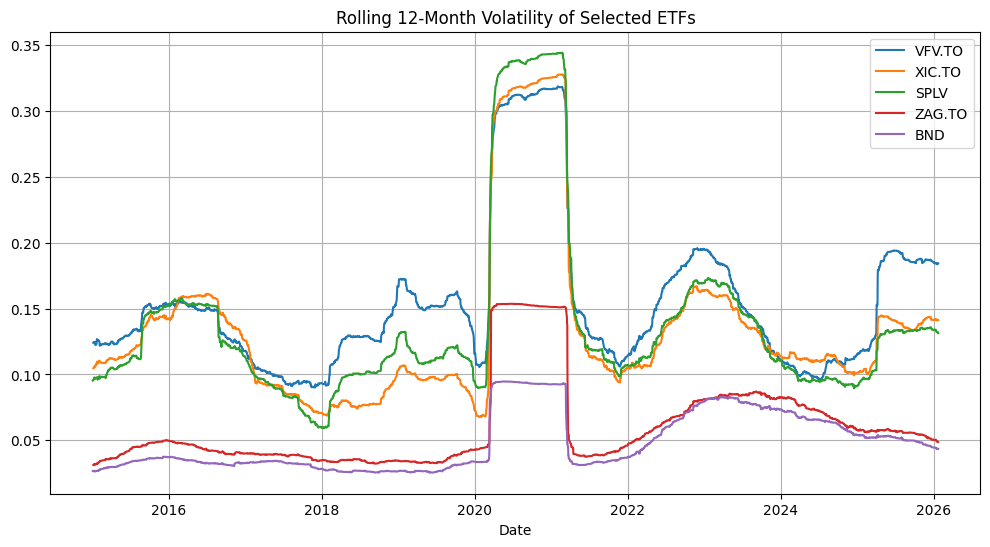

In [11]:
selected_etfs = ["VFV.TO", "XIC.TO", "SPLV", "ZAG.TO", "BND"]

plt.figure(figsize=(12, 6))

for etf in selected_etfs:
    tmp = df[df["Ticker"] == etf]
    plt.plot(tmp["Date"], tmp["Rolling_Volatility"], label=etf)

plt.title("Rolling 12-Month Volatility of Selected ETFs")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.show()

Rolling Risk Insight

Equity ETFs (VFV.TO, XIC.TO, SPLV) show significant volatility spikes during market stress.

Bond ETFs (ZAG.TO, BND) provide risk dampening but are not risk-free.

This validates the use of bonds as stabilizers and explains drawdown behavior observed at the portfolio level.

In [12]:
summary = (
    df.groupby("Ticker")
    .agg(
        Avg_Rolling_Vol=("Rolling_Volatility", "mean"),
        Max_Rolling_Vol=("Rolling_Volatility", "max")
    )
    .sort_values("Avg_Rolling_Vol")
)
summary

,Avg_Rolling_Vol,Max_Rolling_Vol
Ticker,,
BND,0.048454,0.094662
ZAG.TO,0.060276,0.153666
XIC.TO,0.134733,0.327868
VCN.TO,0.136213,0.327781
SPLV,0.138228,0.344332
VDY.TO,0.139977,0.396104
SCHD,0.152384,0.346251
VFV.TO,0.153692,0.318821
SPY,0.164872,0.336464


## ETF Statistical Analysis Modules (Low-to-Moderate Risk)
## Assumes you already have:
###   adj_close_df: DataFrame indexed by Date, columns = tickers, values = Adj Close
### Tickers example: equities (SPY, QQQ, SCHD, VIG, QUAL) + hedges (TLT, GLD, IAU)


In [13]:
TRADING_DAYS = 252
ROLL_6M = 126
EPS = 1e-12

In [14]:
df["Date"] = pd.to_datetime(df["Date"])

adj_close_df = df.pivot(
    index="Date",
    columns="Ticker",
    values="Adj_Close"
).sort_index()

adj_close_df.head()

Ticker,BND,SCHD,SPLV,SPY,VCN.TO,VDY.TO,VFV.TO,VTI,XIC.TO,ZAG.TO
Date,,,,,,,,,,
2014-01-02,56.922413,8.190218,25.252323,148.986008,19.926352,18.511473,29.308161,77.643303,15.384943,10.325187
2014-01-03,56.929501,8.201497,25.267740,148.961624,19.882280,18.573475,29.215139,77.626976,15.341921,10.332015
2014-01-06,56.979229,8.172167,25.190605,148.529907,19.801487,18.424639,29.181309,77.422791,15.277403,10.338845
2014-01-07,57.050289,8.217293,25.375729,149.442200,19.999796,18.517666,29.714031,77.920967,15.406443,10.366158
2014-01-08,56.865547,8.187958,25.267740,149.474716,20.029177,18.492859,29.773228,77.978142,15.420785,10.372988


In [15]:
# Ensure datetime index + sorted
adj_close_df = adj_close_df.copy()
adj_close_df.index = pd.to_datetime(adj_close_df.index)
adj_close_df = adj_close_df.sort_index()

In [16]:
# Daily returns (simple returns)
ret_df = adj_close_df.pct_change().dropna(how="all")

# Helper: safely get columns that exist
def existing_cols(df, cols):
    return [c for c in cols if c in df.columns]

## Module 1:  "Pain-Adjusted" Screen (ETF Component Selection)

In [17]:
def max_drawdown_from_prices(prices):
    """Max Drawdown from a price series (returns a negative value)"""
    prices = prices.dropna()
    if prices.empty:
        return np.nan
    peak = prices.cummax()
    dd = prices - peak - 1.0
    return dd.min()

In [18]:
def ulcer_index_from_prices(prices: pd.Series) -> float:
    """
    Ulcer Index (UI) measures depth & duration of drawdowns.
    Standard definition uses drawdown percent squared, averaged, then sqrt.
    Returns UI in decimal units (e.g., 0.10 ~ 10%).
    """
    prices = prices.dropna()
    if prices.empty:
        return np.nan
    peak = prices.cummax()
    dd = prices / peak - 1.0  # negative drawdowns
    ui = np.sqrt(np.mean(np.square(dd)))
    return ui

In [19]:
def annualized_return_from_prices(prices: pd.Series, trading_days=TRADING_DAYS) -> float:
    """Geometric annualized return based on start/end and number of observations."""
    prices = prices.dropna()
    if len(prices) < 2:
        return np.nan
    total_return = prices.iloc[-1] / prices.iloc[0]
    n_days = len(prices) - 1
    ann = total_return ** (trading_days / max(n_days, 1)) - 1.0
    return ann

In [20]:
def sortino_ratio_from_returns(returns: pd.Series, risk_free_annual: float = 0.0, trading_days=TRADING_DAYS) -> float:
    """
    Sortino Ratio: (annualized return - rf) / annualized downside deviation
    Downside deviation is computed from returns below the MAR (here MAR = rf daily).
    """
    returns = returns.dropna()
    if returns.empty:
        return np.nan

    rf_daily = (1.0 + risk_free_annual) ** (1.0 / trading_days) - 1.0
    excess = returns - rf_daily

    # Downside returns only (below 0 relative to rf)
    downside = np.minimum(excess, 0.0)

    downside_dev_daily = np.sqrt(np.mean(np.square(downside)))
    downside_dev_annual = downside_dev_daily * np.sqrt(trading_days)

    # Annualized mean excess return (approx)
    ann_excess = excess.mean() * trading_days

    if downside_dev_annual < EPS:
        return np.nan
    return ann_excess / downside_dev_annual

In [21]:
def build_pain_adjusted_screen(
    adj_close_df: pd.DataFrame,
    equity_tickers=None,
    hedge_tickers=None,
    risk_free_annual: float = 0.0
) -> pd.DataFrame:
    """
    Creates ETF metrics table:
      - Annualized Return
      - Sortino Ratio
      - Ulcer Index
      - Max Drawdown
      - Efficiency Score = Annualized Return / Ulcer Index
    """
    if equity_tickers is None:
        equity_tickers = ["SPY", "QQQ", "SCHD", "VIG", "QUAL"]
    if hedge_tickers is None:
        hedge_tickers = ["TLT", "GLD", "IAU"]

    all_tickers = existing_cols(adj_close_df, equity_tickers + hedge_tickers)

    prices = adj_close_df[all_tickers].dropna(how="all")
    rets = prices.pct_change().dropna(how="all")

    rows = []
    for t in all_tickers:
        p = prices[t]
        r = rets[t]

        ann_ret = annualized_return_from_prices(p)
        ui = ulcer_index_from_prices(p)
        mdd = max_drawdown_from_prices(p)
        sortino = sortino_ratio_from_returns(r, risk_free_annual=risk_free_annual)

        eff = np.nan
        if pd.notna(ui) and ui > EPS and pd.notna(ann_ret):
            eff = ann_ret / ui

        category = "Equity" if t in equity_tickers else ("Hedge" if t in hedge_tickers else "Other")

        rows.append({
            "Ticker": t,
            "Category": category,
            "Annualized_Return": ann_ret,
            "Sortino": sortino,
            "Ulcer_Index": ui,
            "Max_Drawdown": mdd,
            "Efficiency_Score": eff
        })

    out = pd.DataFrame(rows).set_index("Ticker")
    out = out.sort_values("Efficiency_Score", ascending=False)
    return out

In [22]:
# Run module 1 
equity_list = ["SPY", "QQQ", "SCHD", "VIG", "QUAL"]
hedge_list = ["TLT", "GLD", "IAU"]

screen_df = build_pain_adjusted_screen(adj_close_df, equity_tickers=equity_list, hedge_tickers=hedge_list, risk_free_annual=0.0)

print("Module 1: Pain-Adjusted ETF Screen (Ranked by Efficiency Score)")
display(screen_df)

top_equities = screen_df[screen_df["Category"] == "Equity"].head(2).index.tolist()
top_hedge = screen_df[screen_df["Category"] == "Hedge"].head(1).index.tolist()

print(f"\nTop 2 Equity ETFs (Efficiency): {top_equities}")
print(f"Top 1 Hedge/Bond ETF (Efficiency): {top_hedge}")

Module 1: Pain-Adjusted ETF Screen (Ranked by Efficiency Score)


,Category,Annualized_Return,Sortino,Ulcer_Index,Max_Drawdown,Efficiency_Score
Ticker,,,,,,
SPY,Equity,0.135765,1.156944,0.066965,-114.622192,2.027403
SCHD,Equity,0.111250,1.045008,0.055291,-6.321311,2.012085



Top 2 Equity ETFs (Efficiency): ['SPY', 'SCHD']
Top 1 Hedge/Bond ETF (Efficiency): []


In [23]:
def rolling_corr_plot(
    returns_df,
    benchmark="SPY",
    hedges=("GLD", "TLT"),
    window=126,
    title=None
):
    # Keep only tickers that exist
    cols = [c for c in [benchmark, *hedges] if c in returns_df.columns]
    if benchmark not in cols:
        raise ValueError(f"Benchmark '{benchmark}' not found in returns_df columns.")
    if len(cols) < 2:
        raise ValueError("Need at least 1 hedge ticker that exists in the data.")

    bench = returns_df[benchmark]

    plt.figure(figsize=(12, 5))

    for h in hedges:
        if h not in returns_df.columns:
            continue
        corr = bench.rolling(window).corr(returns_df[h])
        plt.plot(corr.index, corr.values, label=f"{benchmark} vs {h}")

    plt.axhline(0, linestyle="--", alpha=0.6)
    plt.title(title or f"Rolling {window}-Day Correlation: {benchmark} vs Hedges")
    plt.xlabel("Date")
    plt.ylabel("Correlation")
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
import yfinance as yf

In [25]:
hedges = yf.download(
    ["GLD", "TLT"],
    start=ret_df.index.min(),
    end=ret_df.index.max(),
    progress=False
)

hedges.head()

Price            Close                   High                    Low  \
Ticker             GLD        TLT         GLD        TLT         GLD   
Date                                                                   
2014-01-03  119.290001  73.843124  119.620003  74.045493  118.589996   
2014-01-06  119.500000  74.153893  120.389999  74.442993  117.110001   
2014-01-07  118.820000  74.341820  118.919998  74.435775  118.129997   
2014-01-08  118.120003  74.139465  118.519997  74.218968  117.500000   
2014-01-09  118.459999  74.573097  118.690002  74.594779  117.989998   

Price                        Open               Volume           
Ticker            TLT         GLD        TLT       GLD      TLT  
Date                                                             
2014-01-03  73.546801  118.639999  73.582935   5874400  4083800  
2014-01-06  73.987664  119.760002  73.994887  10106500  7796200  
2014-01-07  74.124993  118.459999  74.312909   6433700  4428100  
2014-01-08  73.792544  117.989998  74.045505   7428500  8513000  
2014-01-09  74.088858  118.110001  74.421321   3972800  6991100

In [26]:
print(hedges.columns)

MultiIndex([( 'Close', 'GLD'),
            ( 'Close', 'TLT'),
            (  'High', 'GLD'),
            (  'High', 'TLT'),
            (   'Low', 'GLD'),
            (   'Low', 'TLT'),
            (  'Open', 'GLD'),
            (  'Open', 'TLT'),
            ('Volume', 'GLD'),
            ('Volume', 'TLT')],
           names=['Price', 'Ticker'])


In [ ]:
print(ret_df.columns.tolist())

['BND', 'SCHD', 'SPLV', 'SPY', 'VCN.TO', 'VDY.TO', 'VFV.TO', 'VTI', 'XIC.TO', 'ZAG.TO']


In [28]:
hedges_close = hedges.xs("Close", level="Price", axis=1)

In [ ]:
hedges_close.head()